In [ ]:
%pip install numpy pandas matplotlib scikit-learn
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

np.set_printoptions(precision=3, suppress=True)

# Sistemas de recomendaçao
Alunos: Igor Wallace e Renan Bomtempo


## Introdução

Sistemas de recomendação são algoritmos que sugerem itens para usuários com base em informações coletadas sobre o usuário, itens e outros usuários. Esses sistemas são utilizados em diversas aplicações, como por exemplo, em sites de e-commerce, onde são sugeridos produtos para os usuários, em sites de streaming de vídeo, onde são sugeridos filmes e séries para os usuários, em sites de streaming de música, onde são sugeridos músicas para os usuários, entre outros.

## Tipos de sistemas de recomendação

Existem diversos tipos de sistemas de recomendação, que podem ser classificados de acordo com a forma como as informações são coletadas e utilizadas para gerar as recomendações. Os principais tipos de sistemas de recomendação são os seguintes:

 - **Baseados em conteúdo**: são sistemas que sugerem itens similares aos que o usuário já consumiu. Por exemplo, se um usuário assistiu a um filme de ação, o sistema pode sugerir outros filmes de ação para o usuário.
 - **Baseados em filtragem colaborativa**: são sistemas que sugerem itens que usuários similares ao usuário já consumiram. Por exemplo, se um usuário assistiu a um filme de ação, e outro usuário também assistiu a esse filme, o sistema pode sugerir outros filmes de ação para o segundo usuário.

Neste trabalho iremos tratar do problema de econtrar similaridade entre itens em sistemas de filtragem colaborativa.

## A modelagem do problema

### O cenário
De um lado temos uma enorme coleçao de filmes e séries disponíveis, e do outro temos um conjunto de usuários que desejam assistir a filmes e séries. Nosso objetivo é utilizar as avaliações dos usuários para identificar filmes que são similares. Neste trabalho utilizaremos o dataset de avalições da plataforma Letterboxd (disponível em https://www.kaggle.com/datasets/samlearner/letterboxd-movie-ratings-data).

In [ ]:
# importando o dataset
#dataset_path = '/content/drive/MyDrive/Areas/Faculdade/materias/_periodo_atual/ALN-algebra_linear_numerica/trabalho-pratico/recomendacao/dataset/ratings_export.csv'
dataset_path = 'dataset/ratings_export.csv'

ratings_data = pd.read_csv(dataset_path, header=0, engine='python')
ratings_data.drop(['_id'], axis=1, inplace=True)
ratings_data.head()

movie_id  rating_val     user_id
0        feast-2014           7  deathproof
1       loving-2016           7  deathproof
2  scripted-content           7  deathproof
3        the-future           4  deathproof
4              mank           5  deathproof

In [ ]:
# COunt the number of unique elements in a column
ratings_data['user_id'].nunique()

# Count the average number of ratings per user
ratings_data.groupby('user_id')['rating_val'].count().mean()

# Create a new dataframe with user and the number of ratings they have
user_ratings = pd.DataFrame(ratings_data.groupby('user_id')['rating_val'].count())
user_ratings.head()

rating_val
user_id                   
007filmreviwer        2243
007hertzrumble        1997
0o0o0o0o               100
11122001               325
127gbh                1615

Text(0.5, 1.0, 'Number of users with each number of ratings')

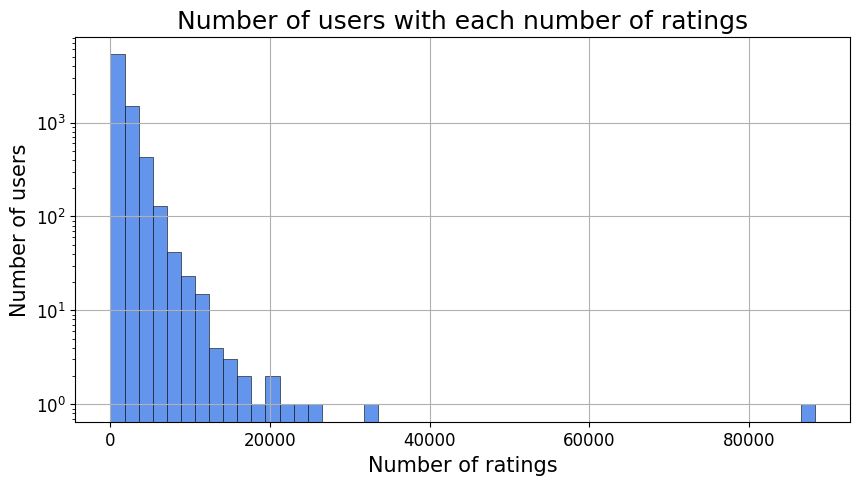

In [ ]:
# List of colors: https://matplotlib.org/3.1.0/gallery/color/named_colors.html
axes = user_ratings['rating_val'].hist(bins=50, log=True, figsize=(10,5), color="cornflowerblue", edgecolor="black", linewidth=0.4, xlabelsize=12, ylabelsize=12)
axes.set_xlabel("Number of ratings", fontsize=15)
axes.set_ylabel("Number of users", fontsize=15)
axes.set_title("Number of users with each number of ratings", fontsize=18)

In [ ]:
# COunt the number of unique elements in a column
ratings_data['movie_id'].nunique()

# Count the average number of ratings per movie
ratings_data.groupby('movie_id')['rating_val'].count().mean()

# # Create a new dataframe with user and the number of ratings they have
movie_ratings = pd.DataFrame(ratings_data.groupby('movie_id')['rating_val'].count())
movie_ratings.head()

rating_val
movie_id                                           
0-uhr-15-zimmer-9                                 2
00-00                                             3
00-08                                            19
00-schneider-im-wendekreis-der-eidechse          15
00-schneider-jagd-auf-nihil-baxter               25

Text(0.5, 1.0, 'Number movies with each number of ratings')

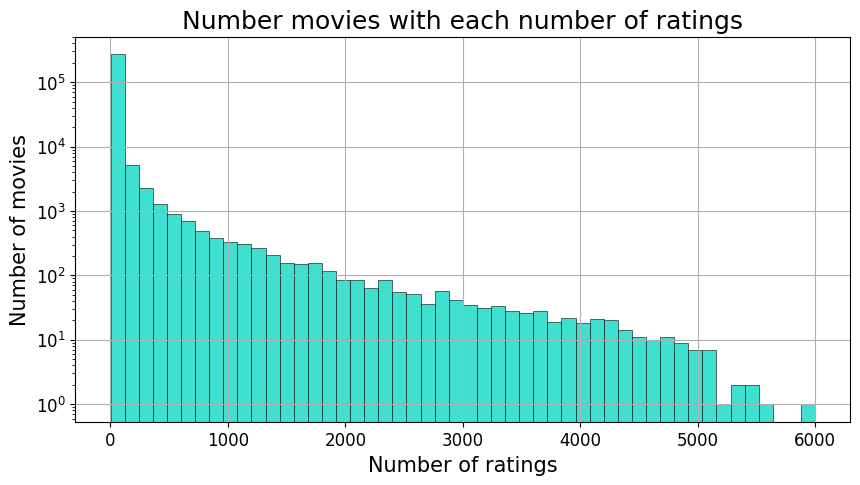

In [ ]:
axes = movie_ratings['rating_val'].hist(bins=50, log=True, figsize=(10,5), color="turquoise", edgecolor="black", linewidth=0.4, xlabelsize=12, ylabelsize=12)
axes.set_xlabel("Number of ratings", fontsize=15)
axes.set_ylabel("Number of movies", fontsize=15)
axes.set_title("Number movies with each number of ratings", fontsize=18)

Porém, este dataset gera uma matriz muito esparsa (muitos valores nulos), o que dificulta a recomendação de filmes para usuários. Para melhorar as recomendações, vamos selecionar os 1.000 usuários que mais avaliaram filmes e os 30.000 filmes mais avaliados, e utilizaremos apenas as avaliações desses usuários e filmes.

In [ ]:
TOP_RATED_MOVIES_NUM = 10000
MOST_RATED_USERS_NUM = 1000

# selecionar os 1000 usuarios com maior numero de avaliações
ratings_data_10000 = ratings_data.groupby('user_id').size().sort_values(ascending=False)[:MOST_RATED_USERS_NUM]
ratings_data_10000 = ratings_data[ratings_data['user_id'].isin(ratings_data_10000.index)]

ratings_data_10000_pivot = ratings_data_10000.pivot_table(index='user_id', columns='movie_id', values='rating_val')

# substituir os valores NaN pela media de avaliações do filme (coluna) em questão
ratings_data_10000_pivot.fillna(0, inplace=True)

# converter a matriz em um array numpy
ratings_matrix_10000 = ratings_data_10000_pivot.values

# count the number of ratings per column and filter out the top 1000 most rated movies
ratings_per_movie = np.sum(ratings_matrix_10000 != 0, axis=0)
top_rated_movies = ratings_per_movie.argsort()[::-1][:TOP_RATED_MOVIES_NUM]
ratings_matrix_10000 = ratings_matrix_10000[:, top_rated_movies]

ratings_data_10000_pivot = ratings_data_10000_pivot.iloc[:, top_rated_movies]

print("Conjunto de dados a ser utilizado ({} usuarios x {} filmes):".format(ratings_matrix_10000.shape[0], ratings_matrix_10000.shape[1]))
ratings_data_10000_pivot.head()


Conjunto de dados a ser utilizado (1000 usuarios x 10000 filmes):


movie_id    mad-max-fury-road  get-out-2017  the-shining  alien  \
user_id                                                           
12pt9                     0.0           0.0          0.0    0.0   
2manydvds                 0.0           9.0          9.0    8.0   
_dylarama_                8.0           9.0          9.0    8.0   
aadya                    10.0           9.0          9.0   10.0   
aar0n_r_h                 8.0          10.0          8.0    8.0   

movie_id    star-wars-the-force-awakens  the-thing  \
user_id                                              
12pt9                               0.0        0.0   
2manydvds                           7.0        8.0   
_dylarama_                          8.0        8.0   
aadya                               8.0       10.0   
aar0n_r_h                           8.0       10.0   

movie_id    once-upon-a-time-in-hollywood  django-unchained  jaws  \
user_id                                                             
12pt9                                 0.0               0.0   0.0   
2manydvds                             7.0               6.0   8.0   
_dylarama_                            6.0               8.0   8.0   
aadya                                 0.0               0.0  10.0   
aar0n_r_h                             0.0              10.0  10.0   

movie_id    blade-runner  ...  pyaasa  dont-bother-to-knock  love-liza  \
user_id                   ...                                            
12pt9                8.0  ...     0.0                   0.0        0.0   
2manydvds            9.0  ...     0.0                   8.0        0.0   
_dylarama_           8.0  ...     0.0                   0.0        0.0   
aadya                8.0  ...     8.0                   0.0        0.0   
aar0n_r_h            8.0  ...     0.0                   0.0        6.0   

movie_id    what-have-i-done-to-deserve-this  \
user_id                                        
12pt9                                    0.0   
2manydvds                                0.0   
_dylarama_                               0.0   
aadya                                    0.0   
aar0n_r_h                                0.0   

movie_id    doctor-who-the-day-of-the-doctor  godzilla-against-mechagodzilla  \
user_id                                                                        
12pt9                                    0.0                             0.0   
2manydvds                                0.0                             0.0   
_dylarama_                               0.0                             0.0   
aadya                                    0.0                             7.0   
aar0n_r_h                                0.0                             0.0   

movie_id    dickie-roberts-former-child-star  shermans-march  ptu  \
user_id                                                             
12pt9                                    0.0             0.0  0.0   
2manydvds                                6.0             0.0  0.0   
_dylarama_                               0.0             0.0  0.0   
aadya                                    0.0             0.0  0.0   
aar0n_r_h                                1.0             0.0  0.0   

movie_id    the-devil-and-father-amorth  
user_id                                  
12pt9                               0.0  
2manydvds                           0.0  
_dylarama_                          0.0  
aadya                               0.0  
aar0n_r_h                           0.0  

[5 rows x 10000 columns]

Ainda assim, a matriz continua muito esparsa. Como tentativa de melhorar a qualidade das recomendações, vamos preencher os valores faltantes com a média das avaliações de cada usuário. Existem diversas outras técnicas específicas para o preenchimento desses valores, porém utilizaremos a abordagem mais simples neste trabalho.

In [ ]:
# fill 0 values with the mean rating of the user
for i in range(ratings_matrix_10000.shape[0]):
    ratings_matrix_10000[i, :] = np.where(ratings_matrix_10000[i, :] == 0, np.mean(ratings_matrix_10000[i, :]), ratings_matrix_10000[i, :])

ratings_matrix_10000

array([[ 0.49 ,  0.49 ,  0.49 , ...,  0.49 ,  0.49 ,  0.49 ],
       [ 3.131,  9.   ,  9.   , ...,  3.131,  3.131,  3.131],
       [ 8.   ,  9.   ,  9.   , ...,  1.927,  1.927,  1.927],
       ...,
       [ 9.   , 10.   , 10.   , ...,  2.955,  2.955,  2.955],
       [ 9.   ,  8.   , 10.   , ...,  2.664,  2.664,  1.   ],
       [10.   , 10.   ,  9.   , ...,  1.428,  1.428,  1.428]])

### Formulação matemática
Seja $U$ o conjunto de usuários e $I$ o conjunto de filmes e séries, e seja $\mathcal R $ um espaço vetorial $|I|$-dimensional sobre o corpo dos números reais $\mathbb{R}$. Cada vetor $r_u \in \mathcal R$ associa um usuário $u \in U$ às notas dadas por ele aos filmes e séries em $I$, de tal forma que a $i$-ésima coordenada de $r_u$ corresponde à nota dada pelo usuário $u$ ao filme ou série $i$.

Nosso dataset nada mais é do que um conjunto destes vetores, que representamos na forma de uma matriz $R \in \mathbb{R}^{|U| \times |I|}$, onde cada linha $u$ corresponde ao vetor $r_u$.

Dado um filme $i$ queremos encontrar um outro filme $j$ que seja similar utilizando apenas os dados contidos na nossa matriz. Para isso, precisamos extrair as informações relevantes que relacionam filmes por meio das notas dos usuarios.


### Utilizando SVD para extrair informações relevantes

Para extrair os dados que estamos interessados, podemos utilizar a decomposição SVD (Singular Value Decomposition). A decomposição SVD de uma matriz $R \in \mathbb{R}^{m \times n}$ é dada por $R = U \Sigma V^T$, onde $U \in \mathbb{R}^{m \times m}$ e $V \in \mathbb{R}^{n \times n}$ são matrizes ortogonais, e $\Sigma \in \mathbb{R}^{m \times n}$ é uma matriz diagonal com entradas não-negativas.

A matriz $U$ codifica informações sobre os usuários, a matriz $V$ codifica informações sobre os filmes e séries, e a matriz $\Sigma$ codifica a importância relativa de cada informação. Utilizando apenas um subconjunto de $k$ colunas de $U$, associados aos maiores valores singulares de $\Sigma$, podemos considerar apenas as informações mais relevantes para a recomendação de filmes e séries.

#### Implementação do SVD

Abaixo, realizamos uma implementação mais ingênua do SVD, que utiliza o método das potências para encontrar os maiores vetores singulares.

In [ ]:
def svd_power_iteration_1d(matrix_1d, epsilon, max_iteration):
    b_k = np.random.rand(matrix_1d.shape[1])

    n, m = matrix_1d.shape

    if n > m:
        B = np.dot(matrix_1d.T, matrix_1d)
    else:
        B = np.dot(matrix_1d, matrix_1d.T)

    for _ in range(max_iteration):
        b_k1 = b_k
        b_k = np.dot(B, b_k)
        b_k_norm = np.linalg.norm(b_k)
        b_k = b_k / b_k_norm

        if abs(np.dot(b_k, b_k1)) > 1 - epsilon:
            return b_k

def svd_recommender(matrix, epsilon=1e-3, max_iteration=1000):
    n, m = matrix.shape
    k = min(n, m)
    svd = []
    for i in range(k):
        matrix_1d = matrix.copy()

        for sv, svd_u, svd_v in svd[:i]:
            matrix_1d -= sv * np.outer(svd_u, svd_v)

        if n > m:
            v = svd_power_iteration_1d(matrix_1d, epsilon, max_iteration)
            u_unnormalized = np.dot(matrix_1d, v)
            sigma = np.linalg.norm(u_unnormalized)
            u = u_unnormalized / sigma
        else:
            u = svd_power_iteration_1d(matrix_1d.T, epsilon, max_iteration)
            v_unnormalized = np.dot(matrix_1d.T, u)
            sigma = np.linalg.norm(v_unnormalized)
            v = v_unnormalized / sigma

        svd.append((sigma, u, v))

    # sort by singular value in descending order
    svd = sorted(svd, key=lambda t: t[0])[::-1]

    # convert the list of (sigma, u, v) tuples into the matrices U, V and vector s
    s, us, vs = zip(*svd)
    U = np.column_stack(us)
    V = np.column_stack(vs)
    S = np.array(s)

    return U, S, V


In [ ]:
u, s, v = svd_recommender(ratings_matrix_10000)

U: (1000, 1000)
S: (1000,)
V: (1000, 10000)


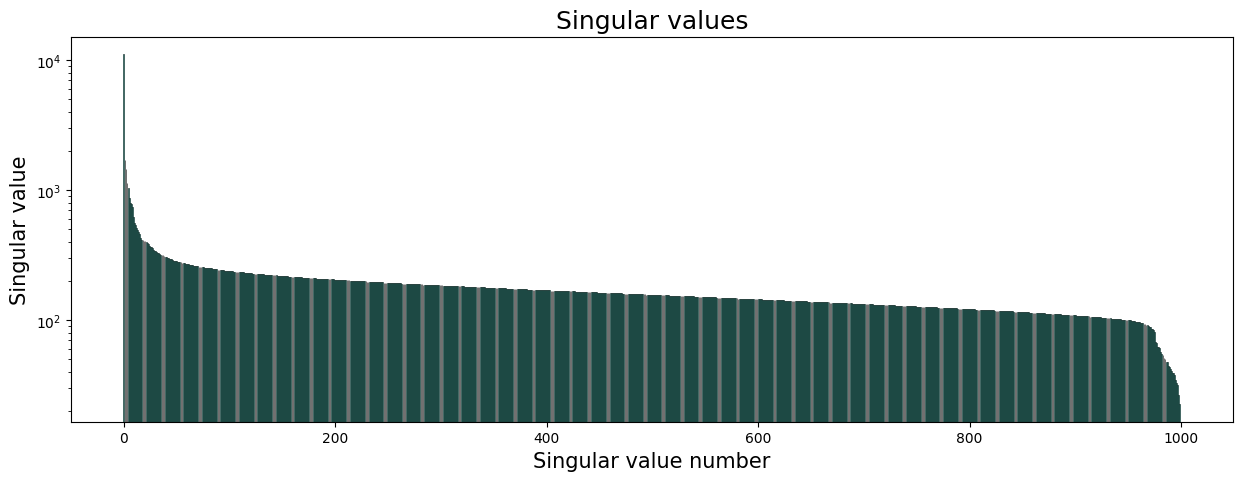

In [ ]:
print('U:', u.shape)
print('S:', s.shape)
print('V:', v.shape)

# plot singular values as bars in log scale
plt.figure(figsize=(15, 5))
plt.bar(range(len(s)), s, log=True, color="turquoise", edgecolor="black", linewidth=0.4)
plt.xlabel("Singular value number", fontsize=15)
plt.ylabel("Singular value", fontsize=15)
plt.title("Singular values", fontsize=18)
plt.show()

### Definindo similaridade

A similaridade entre filmes pode ser obitida por meio do cálculo da similaridade cosseno entre os vetores que representam os filmes, que está codificada no vetor de vetores $V$ obtido pela decomposição SVD da matriz $R$. Dado um valor $k$ de truncamento da decomposição SVD, podemos definir a similaridade entre dois filmes $i$ e $j$ como:

$$
\text{sim}(i, j) = \frac{V_i \cdot V_j}{\|V_i\| \|V_j\|}
$$

onde $V_i$ e $V_j$ são, respectivamente, a $i$-ésima e a $j$-ésima coluna da matriz $V$.

In [ ]:
def cosine_similarity(matrix):
    # compute the dot product between each row with each other row
    dot_product = np.dot(matrix, matrix.T)

    # compute the L2 norm of each row
    norm = np.linalg.norm(matrix, axis=1, keepdims=True)

    # compute the cosine similarity matrix as dot product divided by L2 norm
    return dot_product / (norm * norm.T)

# get the most similar movies for a given movie i
def get_similar_movies(recomend_count, movie_id, movies_similarity):
    recomend_count = recomend_count + 1

    # obtem a coluna do filme em questão
    movie_similarity = movies_similarity[movie_id]

    # ordena os filmes pela similaridade
    movie_similarity_sorted = np.argsort(movie_similarity)[::-1]

    # obtem os nomes dos filmes
    movie_names = ratings_data_10000_pivot.columns[movie_similarity_sorted]

    # obtem os scores de similaridade
    movie_scores = movie_similarity[movie_similarity_sorted]

    # cria uma tupla
    res =  list(zip(movie_names[:recomend_count], movie_scores[:recomend_count]))

    # cria uma tabela com os resultados
    df = pd.DataFrame(res, columns=['movie', 'similarity'])

    return df

In [ ]:

import requests
import io

movie_data = pd.read_csv('dataset/movie_data.csv', header=0, engine='python')

def plot_similar_movies(recomend_count, movie_id, movies_similarity):
    fig, axs = plt.subplots(1, 6, figsize=(40, 10))

    n = 0
    for i in get_similar_movies(recomend_count, movie_id, movies_similarity).iterrows():
        if n == 6:
            break
        movie_id = i[1]['movie']

        # Get the image URL for the movie
        image_url = movie_data[movie_data['movie_id'] == movie_id]['image_url'].values[0]

        image_url = "https://a.ltrbxd.com/resized/{}.jpg".format(image_url)

        # Download the image
        a = requests.get(image_url)

        # Convert the image to a numpy array
        img = plt.imread(io.BytesIO(a.content), format='JPG')

        # Get the movie name from the movie_title column of movie_data dataframe
        movie_name = movie_data[movie_data['movie_id'] == movie_id]['movie_title'].values[0]

        # Plot the image in the corresponding subplot
        axs[n].imshow(img)
        axs[n].set_title("{}".format(movie_name), fontsize=20)
        axs[n].axis('off')
        n = n + 1
    plt.show()

In [ ]:
# valor deve ser menor que MOST_RATED_USERS_NUM
k = 90

# calcula a similaridade entre os filmes
movies_similarity = cosine_similarity(v.T[:, :k])

         movie  similarity
0        alien    1.000000
1       aliens    0.690313
2         jaws    0.686962
3    the-thing    0.630941
4  the-shining    0.581059
5    star-wars    0.560278


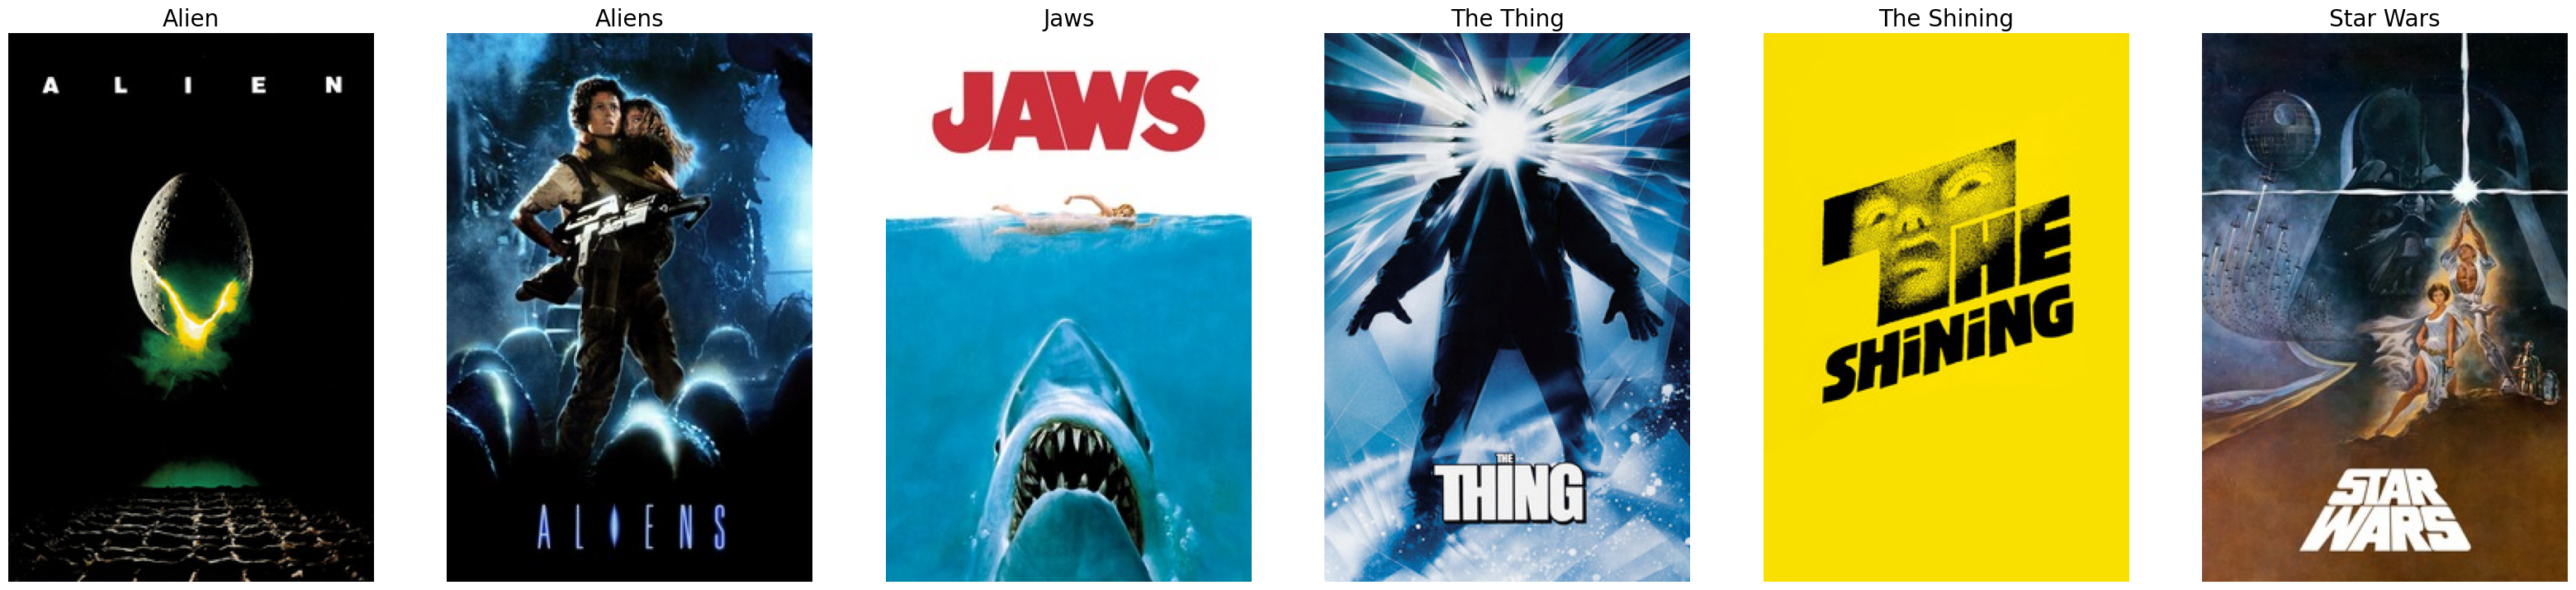

                     movie  similarity
0             blade-runner    1.000000
1  the-empire-strikes-back    0.593367
2                star-wars    0.580730
3              the-shining    0.555714
4                    alien    0.555178
5     2001-a-space-odyssey    0.534880


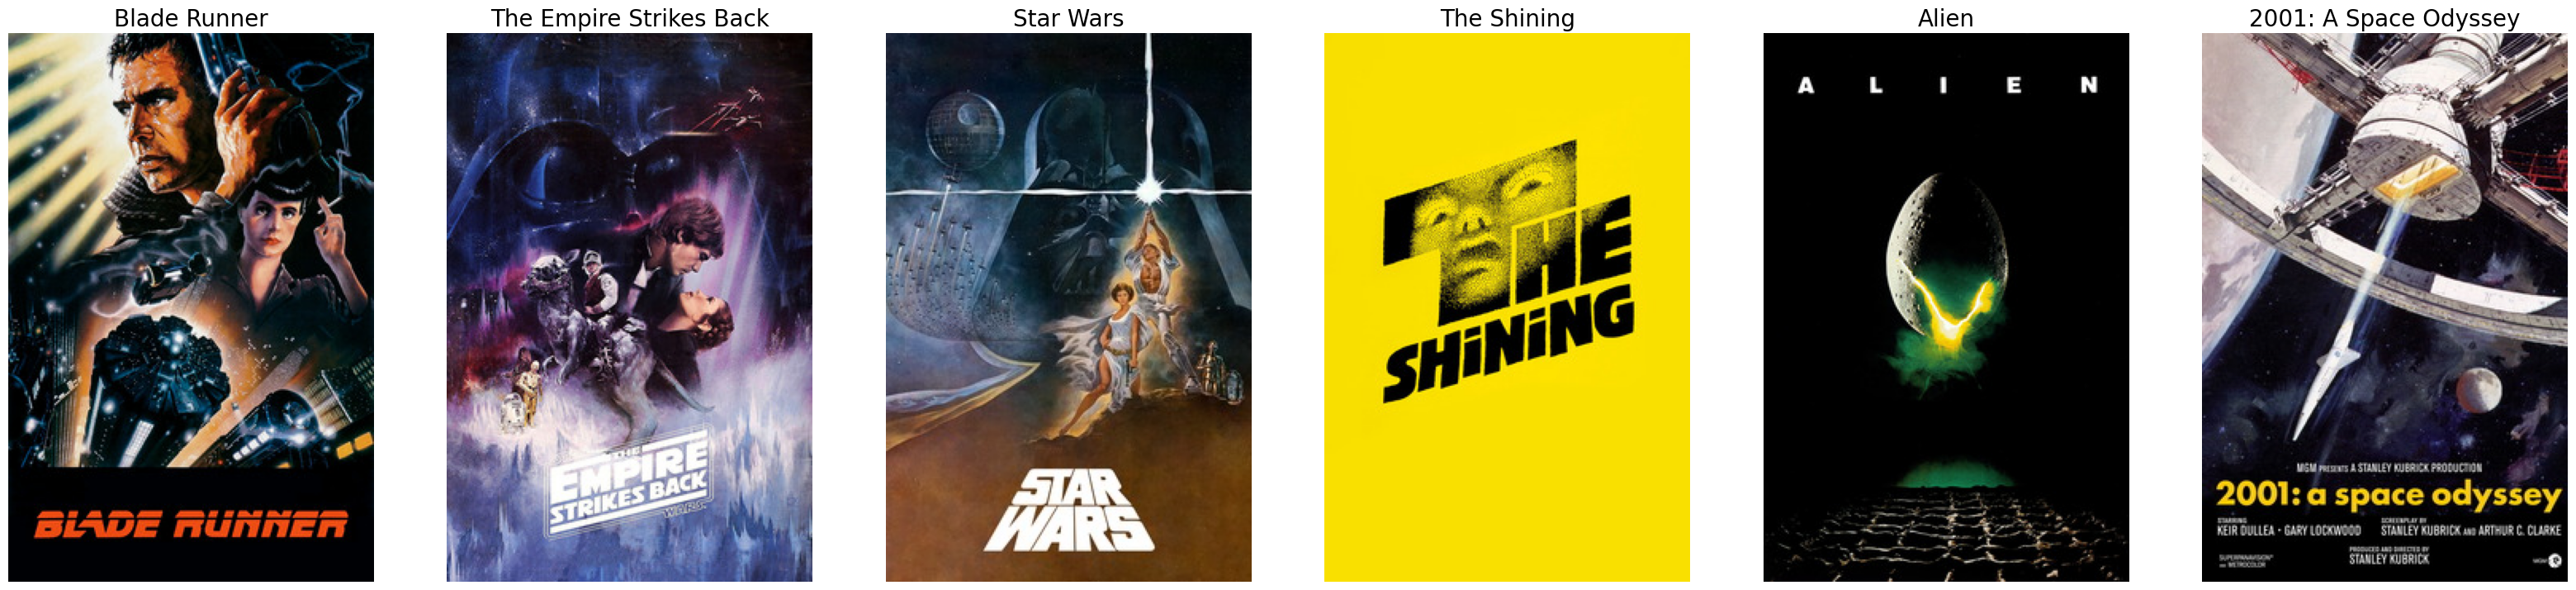

                movie  similarity
0                jaws    1.000000
1               alien    0.686962
2              psycho    0.635051
3  back-to-the-future    0.600368
4         taxi-driver    0.559800
5           the-thing    0.557594


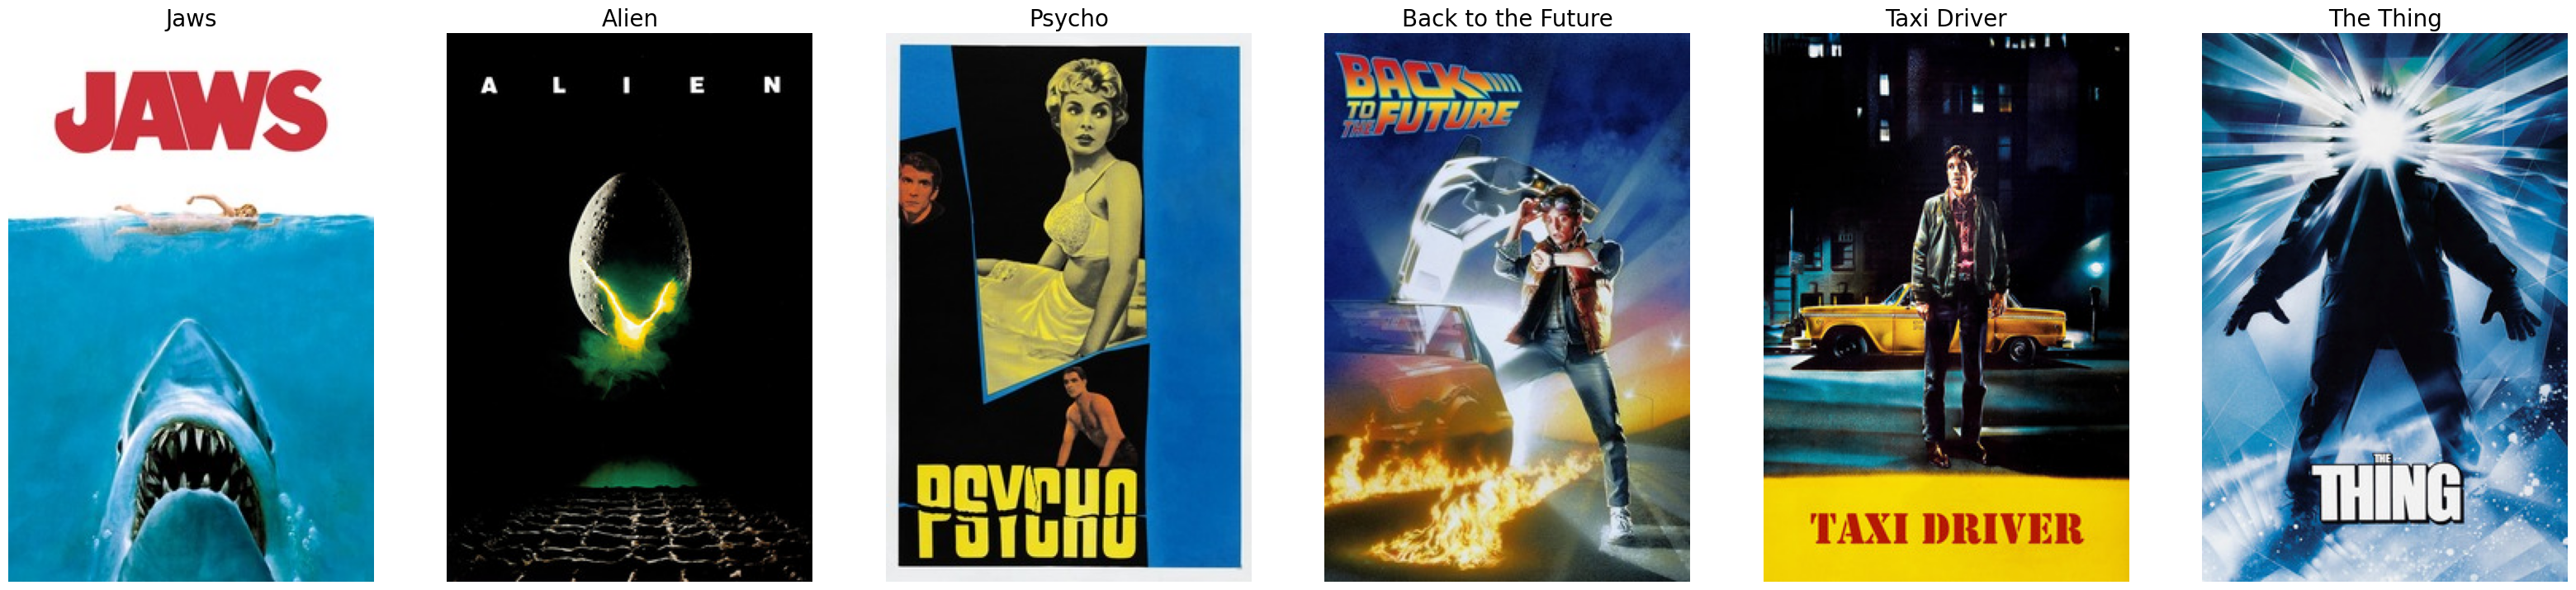

In [ ]:
movies = [3, 9, 8]
for movie in movies:
    print(get_similar_movies(5, movie, movies_similarity))
    plot_similar_movies(5, movie, movies_similarity)